In [13]:
import pandas as pd
import matplotlib.pyplot as plt
import os 
os.getcwd()


'/home/riccardo/WORK-RESEARCH/MirrorRL'

<AxesSubplot:xlabel='time_total_s'>

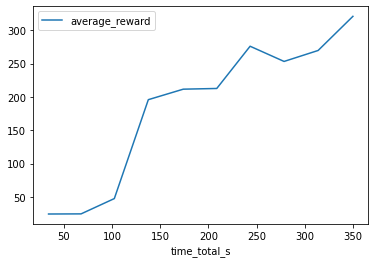

In [14]:
df = pd.read_csv("ray_results/run_2022-05-13_17-28-00/run_4626c_00000_0_batch_size=64,eta=0.12036,gamma=0.99,lr_model=0.001,max_replay_memory_size=10000,min_grad_steps_per_iter=10000,n_2022-05-13_17-28-01/progress.csv")
df.plot(x="time_total_s", y="average_reward")

In [15]:
all_files = [   
                "run_4626c_00000_0_batch_size=64,eta=0.12036,gamma=0.99,lr_model=0.001,max_replay_memory_size=10000,min_grad_steps_per_iter=10000,n_2022-05-13_17-28-01",
                "run_4626c_00001_1_batch_size=64,eta=2.8339,gamma=0.99,lr_model=0.001,max_replay_memory_size=10000,min_grad_steps_per_iter=10000,nb_2022-05-13_17-28-03",
                "run_4626c_00002_2_batch_size=64,eta=1.3993,gamma=0.99,lr_model=0.001,max_replay_memory_size=10000,min_grad_steps_per_iter=10000,nb_2022-05-13_17-28-03",
                "run_4626c_00003_3_batch_size=64,eta=6.0054,gamma=0.99,lr_model=0.001,max_replay_memory_size=10000,min_grad_steps_per_iter=10000,nb_2022-05-13_17-28-03"
            ]
# df = pd.concat((pd.read_csv("./run_2022-05-13_17-28-00/"+f+"/progress.csv") for f in all_files))

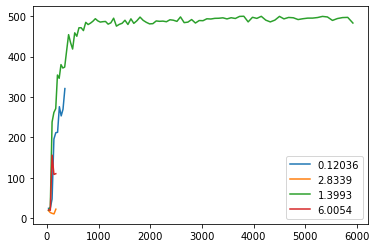

In [19]:
def plot(path, limsup = None):
    for f in all_files:
        data = pd.read_csv(path+f+"/progress.csv")
        fig = plt.figure(0)
        if limsup != None:
            data = data[data["time_total_s"]<limsup]
        labels = f.split(",")
        eta = labels[1][4:]
        # "time_total_s" "average_reward" "q_error_train" "kl" "entorpy"
        plt.plot(data["time_total_s"], data["average_reward"], label=eta)
    plt.legend()
    plt.show()

path = "ray_results/run_2022-05-13_17-28-00/"
plot(path,6000)